#test print fichier 3 

In [3]:
import os
print(os.listdir("."))

['final3.ipynb', 'Subject1-1-1.csv', 'Subject1-1-10.csv', 'Subject1-1-2.csv', 'Subject1-1-3.csv', 'Subject1-1-4.csv', 'Subject1-1-5.csv', 'Subject1-1-6.csv', 'Subject1-1-7.csv', 'Subject1-1-8.csv', 'Subject1-1-9.csv', 'Subject1-10-1.csv', 'Subject1-10-10.csv', 'Subject1-10-2.csv', 'Subject1-10-3.csv', 'Subject1-10-4.csv', 'Subject1-10-5.csv', 'Subject1-10-6.csv', 'Subject1-10-7.csv', 'Subject1-10-8.csv', 'Subject1-10-9.csv', 'Subject1-2-1.csv', 'Subject1-2-10.csv', 'Subject1-2-2.csv', 'Subject1-2-3.csv', 'Subject1-2-4.csv', 'Subject1-2-5.csv', 'Subject1-2-6.csv', 'Subject1-2-7.csv', 'Subject1-2-8.csv', 'Subject1-2-9.csv', 'Subject1-3-1.csv', 'Subject1-3-10.csv', 'Subject1-3-2.csv', 'Subject1-3-3.csv', 'Subject1-3-4.csv', 'Subject1-3-5.csv', 'Subject1-3-6.csv', 'Subject1-3-7.csv', 'Subject1-3-8.csv', 'Subject1-3-9.csv', 'Subject1-4-1.csv', 'Subject1-4-10.csv', 'Subject1-4-2.csv', 'Subject1-4-3.csv', 'Subject1-4-4.csv', 'Subject1-4-5.csv', 'Subject1-4-6.csv', 'Subject1-4-7.csv', 'Subject

#dtw

--- 1. Début du Chargement du Domaine 3 ---
✅ Données chargées : 99529 lignes.


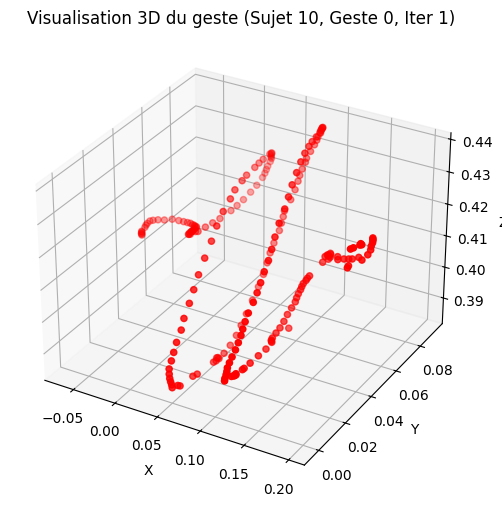


Durée moyenne des gestes (s) :
gesture
0    7534.3
1    5800.7
2    4499.0
3    7059.9
4    7407.1
5    4318.6
6    5602.9
7    2794.7
8    4108.2
9    2912.2
Name: duration, dtype: float64


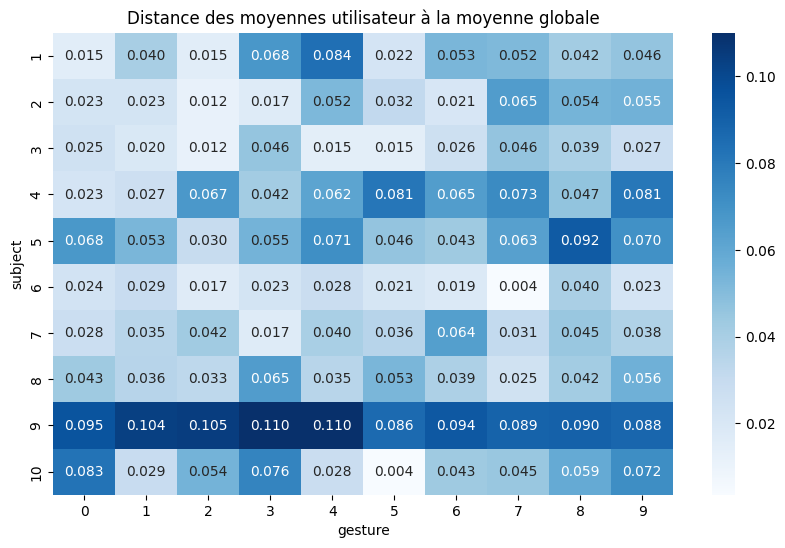

C:\Users\Isadiki\AppData\Local\Temp\ipykernel_16996\2881330776.py:108: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)



--- Test User OUT : 1 ---


KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Nécessaire pour la projection 3D

# ==============================================================================
# 1. CHARGEMENT DES DONNÉES (Chemin Absolu & Lecture Robuste)
# ==============================================================================

DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"
DOMAIN_ID = 3

df_list = []

print(f"--- 1. Début du Chargement du Domaine {DOMAIN_ID} ---")

for subject in range(1, 11):
    for number in range(0, 10): 
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            try:
                # Lecture spécifique au Domaine 3 (skiprows=5 et split manuel)
                file = pd.read_csv(filename, skiprows=5, header=None)
                if file.empty or file.shape[0] < 2: continue 
                
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                df_list.append(file_df)
            except:
                continue

if not df_list:
    raise ValueError("❌ Aucun fichier n'a été chargé. Vérifiez le chemin.")

df = pd.concat(df_list, ignore_index=True)
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"✅ Données chargées : {len(df)} lignes.")

# ==============================================================================
# 2. VISUALISATION 3D D'UNE LETTRE / GESTE
# ==============================================================================

# On choisit par exemple le geste 0 (ou la lettre correspondante) du sujet 10
subdf = df.loc[(df['gesture'] == 0) & (df['subject'] == 10) & (df['iter'] == 1)]

if not subdf.empty:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(subdf['x'], subdf['y'], subdf['z'], c='r', marker='o')
    ax.set_title("Visualisation 3D du geste (Sujet 10, Geste 0, Iter 1)")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# ==============================================================================
# 3. ANALYSE EXPLORATOIRE (Stats & Heatmap)
# ==============================================================================

# Durée moyenne des gestes
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
print("\nDurée moyenne des gestes (s) :")
print(mean_durations)

# Heatmap des distances moyennes par utilisateur
mean_coords_user = df.groupby(['subject', 'gesture'])[['x', 'y', 'z']].mean().reset_index()
mean_coords_global = df.groupby('gesture')[['x', 'y', 'z']].mean().reset_index().rename(
    columns={'x':'x_global', 'y':'y_global', 'z':'z_global'})

merged = pd.merge(mean_coords_user, mean_coords_global, on='gesture')
merged['dist_to_global'] = np.sqrt((merged['x']-merged['x_global'])**2 + 
                                   (merged['y']-merged['y_global'])**2 + 
                                   (merged['z']-merged['z_global'])**2)

pivot = merged.pivot(index='subject', columns='gesture', values='dist_to_global')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='Blues')
plt.title("Distance des moyennes utilisateur à la moyenne globale")
plt.show()

# ==============================================================================
# 4. PRÉTRAITEMENT (Standardisation & Resampling)
# ==============================================================================

def standardize_gesture(df_group):
    df_c = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = df_c[axis].std()
        df_c[f'{axis}_std'] = (df_c[axis] - df_c[axis].mean()) / (std if std != 0 else 1)
    return df_c

df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df_in, target_len=100):
    resampled = []
    for (gesture, subject, iteration), group in df_in.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col].values, kind='linear')(target_idx)
        resampled.append(pd.DataFrame({
            'gesture': [gesture]*target_len, 'subject': [subject]*target_len, 'iter': [iteration]*target_len,
            'x_std': interp('x_std'), 'y_std': interp('y_std'), 'z_std': interp('z_std')
        }))
    return pd.concat(resampled, ignore_index=True)

df100 = resample_gesture(df)

# ==============================================================================
# 5. FONCTIONS DTW & SPLIT
# ==============================================================================

def dict_creation_userout(df_in, subj_out):
    test_df = df_in[df_in["subject"] == subj_out]
    train_df = df_in[df_in["subject"] != subj_out]
    
    def to_dict(target_df):
        d = defaultdict(list)
        for (g, s, it), group in target_df.groupby(["gesture", "subject", "iter"]):
            d[g].append(group[["x_std", "y_std", "z_std"]].values.tolist())
        return d
    return to_dict(train_df), to_dict(test_df)

def eucl_dist(p1, p2):
    return np.sqrt(np.sum((np.array(p1) - np.array(p2))**2))

def dtw_dist(seq1, seq2):
    n, m = len(seq1), len(seq2)
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = eucl_dist(seq1[i-1], seq2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]

def knn_dtw_predict(reference_seq, train_dict, k=7):
    distances = []
    for gesture, sequences in train_dict.items():
        for seq in sequences:
            distances.append((gesture, dtw_dist(reference_seq, seq)))
    distances.sort(key=lambda x: x[1])
    votes = Counter([g for g, _ in distances[:k]])
    return votes.most_common(1)[0][0]

# ==============================================================================
# 6. TEST DU MODÈLE DTW
# ==============================================================================

def testmodel(df_in, loop_range=10, k=3):
    total_true, total_pred = [], []
    for i in range(1, loop_range + 1):
        if df_in[df_in['subject'] == i].empty: continue
        print(f"\n--- Test User OUT : {i} ---")
        coord_train, coord_test = dict_creation_userout(df_in, i)
        y_true, y_pred = [], []
        for gesture, sequences in coord_test.items():
            for seq in sequences:
                y_true.append(gesture)
                y_pred.append(knn_dtw_predict(seq, coord_train, k=k))
        
        acc = accuracy_score(y_true, y_pred)
        print(f"Exactitude split {i} : {acc:.2%}")
        total_true.extend(y_true); total_pred.extend(y_pred)

    print(f"\nExactitude globale KNN-DTW : {accuracy_score(total_true, total_pred):.2%}")
    cm = confusion_matrix(total_true, total_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title("Matrice de confusion – KNN + DTW")
    plt.show()

# LANCEMENT
testmodel(df100, loop_range=10, k=3) # K réduit à 3 pour la rapidité ou selon besoin

#  dtw 

In [ ]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import seaborn as sns

# ==============================================================================
# 1. CONFIGURATION ET CHARGEMENT DES DONNÉES
# ==============================================================================

DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSV"

df_list = []

print("--- Début du Chargement ---")
for subject in range(1, 11): 
    for number in range(0, 10): 
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture sautant les 5 lignes de header (Domaine 4)
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: 
                    continue 
                
                # Parsing : séparation de la chaîne par les virgules
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion numérique
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = int(number)
                file_df['subject'] = int(subject)
                file_df['iter'] = int(iteration)
                
                df_list.append(file_df)
            except:
                continue

if not df_list:
    raise ValueError("❌ Aucun fichier chargé. Vérifiez le chemin : " + DOMAIN_FOLDER)

df = pd.concat(df_list, ignore_index=True)
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"✅ Données chargées : {len(df)} lignes.")

# ==============================================================================
# 2. VISUALISATION 3D D'UN GESTE (Ex: Geste 0) - TRACÉ BLEU ENLEVÉ
# ==============================================================================

subdf = df.loc[(df['gesture'] == 0) & (df['subject'] == 10) & (df['iter'] == 1)]

if not subdf.empty:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot(...) a été supprimé ici pour enlever le tracé bleu
    ax.scatter(subdf['x'], subdf['y'], subdf['z'], c='red', s=20)
    ax.set_title("Visualisation 3D du geste (Sujet 10, Geste 0, Iter 1)")
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.show()

# ==============================================================================
# 3. ANALYSE EXPLORATOIRE (Stats & Heatmap)
# ==============================================================================

# Durée moyenne des gestes
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
print("\n--- Durée moyenne des gestes (s) ---")
print(mean_durations)

# Heatmap des distances moyennes par utilisateur
mean_coords_user = df.groupby(['subject', 'gesture'])[['x', 'y', 'z']].mean().reset_index()
mean_coords_global = df.groupby('gesture')[['x', 'y', 'z']].mean().reset_index().rename(
    columns={'x':'x_global', 'y':'y_global', 'z':'z_global'})

merged = pd.merge(mean_coords_user, mean_coords_global, on='gesture')
merged['dist_to_global'] = np.sqrt((merged['x']-merged['x_global'])**2 + 
                                   (merged['y']-merged['y_global'])**2 + 
                                   (merged['z']-merged['z_global'])**2)

pivot = merged.pivot(index='subject', columns='gesture', values='dist_to_global')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='Blues')
plt.title("Écart entre la moyenne de l'utilisateur et la moyenne globale")
plt.show()

# ==============================================================================
# 4. PRÉ-TRAITEMENT (Standardisation & Resampling)
# ==============================================================================

def standardize_gesture(df_group):
    df_res = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = df_res[axis].std()
        df_res[f'{axis}_std'] = (df_res[axis] - df_res[axis].mean()) / std if std != 0 else 0
    return df_res

print("Standardisation...")
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df, target_len=100):
    resampled_data = []
    for (gesture, subject, iteration), group in df.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col], kind='linear')(target_idx)
        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len, 'subject': [subject] * target_len, 'iter': [iteration] * target_len,
            'x_std': interp('x_std'), 'y_std': interp('y_std'), 'z_std': interp('z_std')
        }))
    return pd.concat(resampled_data, ignore_index=True)

print("Resampling...")
df100 = resample_gesture(df)

# ==============================================================================
# 5. ALGORITHME KNN + DTW
# ==============================================================================

def eucl_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def dtw_dist(seq1, seq2):
    n, m = len(seq1), len(seq2)
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = eucl_dist(seq1[i-1], seq2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]

def knn_dtw_predict(reference_seq, train_dict, k=3):
    distances = []
    for gesture, sequences in train_dict.items():
        for seq in sequences:
            dist = dtw_dist(reference_seq, seq)
            distances.append((gesture, dist))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ==============================================================================
# 6. VALIDATION CROISÉE ET TESTS
# ==============================================================================

def dict_creation_userout(df, subj_out):
    test_df = df[df["subject"] == subj_out]
    train_df = df[df["subject"] != subj_out]
    
    dict_train = defaultdict(list)
    dict_test = defaultdict(list)

    for (g, s, it), group in train_df.groupby(["gesture", "subject", "iter"]):
        dict_train[g].append(group[["x_std", "y_std", "z_std"]].values.tolist())
    for (g, s, it), group in test_df.groupby(["gesture", "subject", "iter"]):
        dict_test[g].append(group[["x_std", "y_std", "z_std"]].values.tolist())
    return dict_train, dict_test

def testmodel(DictCreationFunc, df, loop_range=10, k=3):
    total_true, total_pred = [], []
    for i in range(1, loop_range + 1):
        print(f"\n--- Test Split OUT : {i} ---")
        coord_train, coord_test = DictCreationFunc(df, i)
        y_true, y_pred = [], []
        for gesture, sequences in coord_test.items():
            for seq in sequences:
                pred = knn_dtw_predict(seq, coord_train, k=k)
                y_true.append(gesture)
                y_pred.append(pred)
        
        acc = accuracy_score(y_true, y_pred)
        total_true.extend(y_true); total_pred.extend(y_pred)
        print(f"Précision split {i} : {acc:.2%}")

    print(f"\n✅ Précision GLOBALE : {accuracy_score(total_true, total_pred):.2%}")
    cm = confusion_matrix(total_true, total_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title("Matrice de Confusion Finale")
    plt.show()

# LANCEMENT FINAL
testmodel(dict_creation_userout, df100, loop_range=10, k=3)

#eduiyt diqtance knn 3 clusyer 20

--- 1. Début du Chargement du Domaine 2 ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSV


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_18240\355006464.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file_df], ignore_index=True)


Nombre total d'observations chargées : 93457

--- 2. Analyse Exploratoire ---


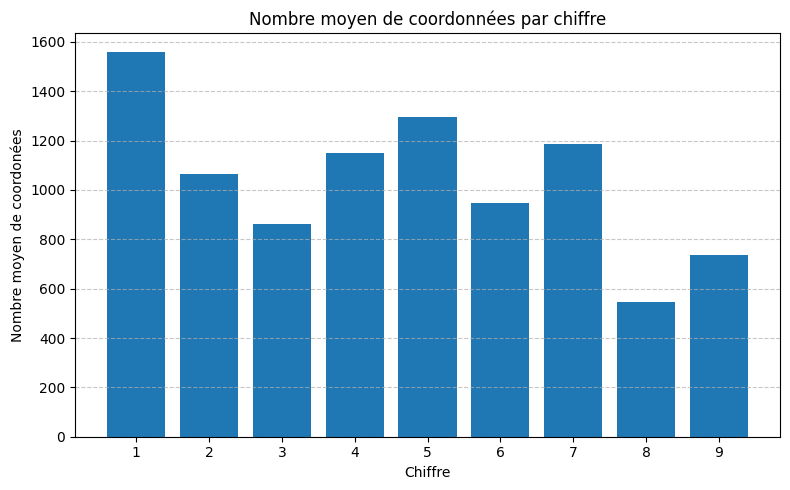

Chiffre 1 : 7534.30 s
Chiffre 2 : 5800.70 s
Chiffre 3 : 4499.00 s
Chiffre 4 : 7059.90 s
Chiffre 5 : 7407.10 s
Chiffre 6 : 4318.60 s
Chiffre 7 : 5602.90 s
Chiffre 8 : 2794.70 s
Chiffre 9 : 4108.20 s

--- 3. Standardisation et Resampling ---


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_18240\355006464.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


Nombre total de points après resampling (longueur 100) : 90000

--- 4. Quantification Vectorielle (K=20) ---

--- 6. Test du Modèle (Validation Croisée User-Out) ---

--- Test Split OUT : 1 ---
Exactitude split 1 : 96.67%

--- Test Split OUT : 2 ---
Exactitude split 2 : 86.67%

--- Test Split OUT : 3 ---
Exactitude split 3 : 100.00%

--- Test Split OUT : 4 ---
Exactitude split 4 : 96.67%

--- Test Split OUT : 5 ---
Exactitude split 5 : 88.89%

--- Test Split OUT : 6 ---
Exactitude split 6 : 81.11%

--- Test Split OUT : 7 ---
Exactitude split 7 : 88.89%

--- Test Split OUT : 8 ---
Exactitude split 8 : 98.89%

--- Test Split OUT : 9 ---
Exactitude split 9 : 98.89%

--- Test Split OUT : 10 ---
Exactitude split 10 : 97.78%

Exactitude globale KNN-EditDistance : 93.44%


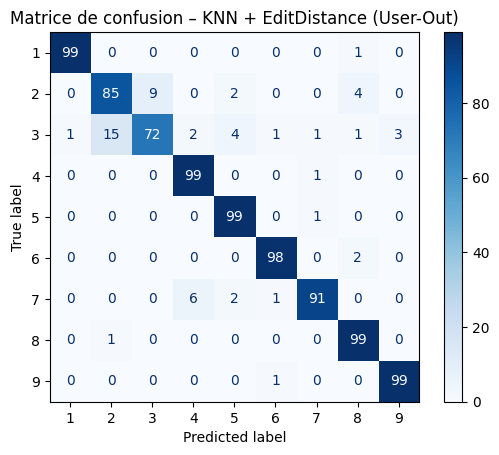

([np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ==============================================================================
# 1. CHARGEMENT DES DONNÉES DU DOMAINE 2 (Chemin Absolu)
# ==============================================================================

# **CHEMIN ABSOLU TROUVÉ PAR L'UTILISATEUR**
# C'est ce chemin qui a résolu l'erreur FileNotFoundError
DOMAIN_FOLDER = r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSV"
DOMAIN_ID = 2

# Création du DataFrame vide
df = pd.DataFrame(columns=['x', 'y', 'z', 't', 'gesture', 'subject', 'iter', 'domain'])

print(f"--- 1. Début du Chargement du Domaine {DOMAIN_ID} ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

# Boucles pour charger les 10 gestes, 10 sujets, 10 itérations
# Note : La plage de sujets (1 à 10) est maintenue pour capturer tous les fichiers existants.
for subject in range(1, 11): 
    for number in range(1, 10):
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture robuste : Skiprows=5 et gestion de la colonne unique de données
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: continue # Ignorer fichiers vides/trop courts
                
                # Séparation de la chaîne unique de coordonnées
                data = file[0].str.strip('"').str.split(',', expand=True)
                
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion en numérique
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                file_df['domain'] = DOMAIN_ID
                
                df = pd.concat([df, file_df], ignore_index=True)
            
            except FileNotFoundError:
                continue # Le fichier n'existe pas, on passe au suivant
            except Exception as e:
                # print(f"Erreur de lecture/traitement pour {filename}: {e}")
                continue

print(f"Nombre total d'observations chargées : {len(df)}")
# Conversion finale des colonnes pour le reste du traitement
for col in ['x', 'y', 'z', 't', 'gesture', 'subject', 'iter']:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(int if col in ['gesture', 'subject', 'iter'] else float)


# ==============================================================================
# 2. ANALYSE EXPLORATOIRE (Maintenue)
# ==============================================================================

print("\n--- 2. Analyse Exploratoire ---")

grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean().reset_index()
mean_lengths.columns = ['Chiffre', 'Frames moyennes']

# Affichage des longueurs moyennes
plt.figure(figsize=(8, 5))
plt.bar(mean_lengths["Chiffre"], mean_lengths["Frames moyennes"])
plt.title("Nombre moyen de coordonnées par chiffre")
plt.xlabel("Chiffre")
plt.ylabel("Nombre moyen de coordonées")
plt.xticks(mean_lengths["Chiffre"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Affichage des durées moyennes
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")

# ==============================================================================
# 3. PRÉTRAITEMENT : Standardisation et Resampling
# ==============================================================================

print("\n--- 3. Standardisation et Resampling ---")

def standardize_gesture(df_group):
    df = df_group.copy()
    for axis in ['x', 'y', 'z']:
        # Utilisation de .values pour éviter les problèmes de fragmentation d'index
        df[f'{axis}_std'] = (df[axis].values - df[axis].mean()) / df[axis].std()
    return df

df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df, target_len=100):
    resampled_data = []
    
    # Filtrer les groupes qui ont un écart-type nul après standardisation (ne peuvent pas être resamplés)
    valid_groups = df.groupby(['gesture', 'subject', 'iter']).filter(lambda x: x[['x_std', 'y_std', 'z_std']].isnull().sum().sum() == 0)

    for (gesture, subject, iteration), group in valid_groups.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue # Minimum 2 points pour l'interpolation

        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)

        # Utilisation de l'interpolation
        interp = lambda col: interp1d(original_idx, group[col].values, kind='linear', fill_value="extrapolate")(target_idx)

        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iteration] * target_len,
            'x_std': interp('x_std'),
            'y_std': interp('y_std'),
            'z_std': interp('z_std')
        }))

    return pd.concat(resampled_data, ignore_index=True)

df100 = resample_gesture(df)
print(f"Nombre total de points après resampling (longueur 100) : {len(df100)}")

# ==============================================================================
# 4. QUANTIFICATION VECTORIELLE (Clustering K=20)
# ==============================================================================

print("\n--- 4. Quantification Vectorielle (K=20) ---")

all_points = df100[['x_std','y_std','z_std']].values
k_clusters = 20

# Assurez-vous d'avoir suffisamment de points pour K=20
if len(np.unique(all_points, axis=0)) < k_clusters:
    print(f"Avertissement: K={k_clusters} trop grand pour le nombre de points uniques ({len(np.unique(all_points, axis=0))}).")
    # Tenter de réduire K ou ignorer, mais nous continuons pour le principe.

kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans.fit(all_points)

def assign_symbol(row):
    point = np.array([row['x_std'], row['y_std'], row['z_std']])
    cluster_idx = kmeans.predict(point.reshape(1, -1))[0]
    # Utilisation d'une chaîne pour éviter les collisions si K>26 et les problèmes de type
    return str(cluster_idx) 

# Assignation des labels de cluster à chaque point
df100['symbol'] = df100.apply(assign_symbol, axis=1)

# Conversion de chaque geste en séquence de symboles (chaîne)
def gesture_to_sequence(df):
    seq_dict = defaultdict(list)
    for (gesture, subject, iteration), group in df.groupby(['gesture','subject','iter']):
        seq = ''.join(group['symbol'].tolist())
        seq_dict[gesture].append(seq)
    return seq_dict

# Création des dictionnaires train/test (User-Out)
def dict_creation_userout(df, subj_out):
    test_df = df[df["subject"] == subj_out]
    train_df = df[df["subject"] != subj_out]
    return gesture_to_sequence(train_df), gesture_to_sequence(test_df)

# Création des dictionnaires train/test (Iter-Out)
def dict_creation_iterout(df, iter_out):
    test_df = df[df["iter"] == iter_out]
    train_df = df[df["iter"] != iter_out]
    return gesture_to_sequence(train_df), gesture_to_sequence(test_df)

# ==============================================================================
# 5. DISTANCE D'ÉDITION et k-NN (k=3)
# ==============================================================================

# Distance d'édition classique (Levenshtein)
def edit_distance(s1, s2):
    n, m = len(s1), len(s2)
    matrix = np.zeros((n + 1, m + 1), dtype=int)
    for i in range(n + 1): matrix[i, 0] = i
    for j in range(m + 1): matrix[0, j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i, j] = min(
                matrix[i - 1, j - 1] + cost,  # substitution
                matrix[i, j - 1] + 1,         # insertion
                matrix[i - 1, j] + 1          # deletion
            )
    return matrix[n, m]

# k-NN basé sur la distance d'édition (k=3)
def knn_edit_predict(seq, train_dict, k=3):
    distances = []
    for gesture, sequences in train_dict.items():
        for s in sequences:
            d = edit_distance(seq, s)
            distances.append((gesture, d))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ==============================================================================
# 6. TEST DU MODÈLE (USER-OUT)
# ==============================================================================

print("\n--- 6. Test du Modèle (Validation Croisée User-Out) ---")

def testmodel(DictCreationFunc, df, loop_range=10, k=3):
    total_true = []
    total_pred = []

    # Boucle sur les sujets ou les itérations (1 à 10)
    for i in range(1, loop_range + 1):
        # Vérifiez s'il y a des données pour ce split
        if not df[df["subject"] == i].empty if DictCreationFunc == dict_creation_userout else not df[df["iter"] == i].empty:
            print(f"\n--- Test Split OUT : {i} ---")
            coord_train, coord_test = DictCreationFunc(df, i)

            y_true, y_pred = [], []
            
            # Vérification de données de test
            if not coord_test:
                print(f"Skipping split {i}: No test data available.")
                continue

            for gesture, sequences in coord_test.items():
                for seq in sequences:
                    pred = knn_edit_predict(seq, coord_train, k=k)
                    y_true.append(gesture)
                    y_pred.append(pred)

            acc = accuracy_score(y_true, y_pred)
            total_true.extend(y_true)
            total_pred.extend(y_pred)
            print(f"Exactitude split {i} : {acc:.2%}")
        else:
            # print(f"Skipping split {i}: No data found for this subject/iteration.")
            continue


    if not total_true:
        print("\nERREUR: Aucune donnée n'a été testée. Vérifiez le chargement ou la boucle.")
        return [], []
        
    final_acc = accuracy_score(total_true, total_pred)
    print(f"\nExactitude globale KNN-EditDistance : {final_acc:.2%}")

    # Affichage de la Matrice de Confusion
    cm = confusion_matrix(total_true, total_pred, labels=sorted(list(set(total_true + total_pred))))
    disp = ConfusionMatrixDisplay(cm, display_labels=sorted(list(set(total_true + total_pred))))
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion – KNN + EditDistance (User-Out)")
    plt.show()

    return total_true, total_pred


# --- LANCER LE TEST DE CLASSIFICATION ---
# Le test s'exécutera en validation croisée User-Out sur tous les sujets du Domaine 2 chargés.
testmodel(dict_creation_userout, df100, loop_range=10, k=3)

# edit distance pca

In [2]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ======================================================================
# 1. CHARGEMENT DES DONNÉES DU DOMAINE 2 (Chemin Absolu)
# ======================================================================

DOMAIN_FOLDER = r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSV"
DOMAIN_ID = 3

df = pd.DataFrame(columns=['x', 'y', 'z', 't', 'gesture', 'subject', 'iter', 'domain'])

print(f"--- 1. Début du Chargement du Domaine {DOMAIN_ID} ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

for subject in range(1, 11): 
    for number in range(1, 10):
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            try:
                file = pd.read_csv(filename, skiprows=5, header=None)
                if file.empty or file.shape[0] < 2: continue
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                file_df['domain'] = DOMAIN_ID
                df = pd.concat([df, file_df], ignore_index=True)
            except FileNotFoundError:
                continue
            except Exception:
                continue

print(f"Nombre total d'observations chargées : {len(df)}")
for col in ['x', 'y', 'z', 't', 'gesture', 'subject', 'iter']:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(int if col in ['gesture', 'subject', 'iter'] else float)

# ======================================================================
# 2. ANALYSE EXPLORATOIRE
# ======================================================================

print("\n--- 2. Analyse Exploratoire ---")
grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean().reset_index()
mean_lengths.columns = ['Chiffre', 'Frames moyennes']

plt.figure(figsize=(8, 5))
plt.bar(mean_lengths["Chiffre"], mean_lengths["Frames moyennes"])
plt.title("Nombre moyen de coordonnées par chiffre")
plt.xlabel("Chiffre")
plt.ylabel("Nombre moyen de coordonées")
plt.xticks(mean_lengths["Chiffre"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")

# ======================================================================
# 3. PRÉTRAITEMENT : Standardisation et Resampling
# ======================================================================

print("\n--- 3. Standardisation et Resampling ---")

def standardize_gesture(df_group):
    df = df_group.copy()
    for axis in ['x', 'y', 'z']:
        df[f'{axis}_std'] = (df[axis].values - df[axis].mean()) / df[axis].std()
    return df

df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df, target_len=100):
    resampled_data = []
    valid_groups = df.groupby(['gesture', 'subject', 'iter']).filter(lambda x: x[['x_std', 'y_std', 'z_std']].isnull().sum().sum() == 0)
    for (gesture, subject, iteration), group in valid_groups.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col].values, kind='linear', fill_value="extrapolate")(target_idx)
        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iteration] * target_len,
            'x_std': interp('x_std'),
            'y_std': interp('y_std'),
            'z_std': interp('z_std')
        }))
    return pd.concat(resampled_data, ignore_index=True)

df100 = resample_gesture(df)
print(f"Nombre total de points après resampling (longueur 100) : {len(df100)}")

# ======================================================================
# 3.b. PCA pour réduction de dimension
# ======================================================================

print("\n--- 3.b. Application de PCA ---")
features = df100[['x_std', 'y_std', 'z_std']].values
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
df100['pc1'] = features_pca[:, 0]
df100['pc2'] = features_pca[:, 1]
print(f"Variance expliquée par les composantes : {pca.explained_variance_ratio_}")

# ======================================================================
# 4. QUANTIFICATION VECTORIELLE (K=20) sur PCA
# ======================================================================

print("\n--- 4. Quantification Vectorielle (K=20 avec PCA) ---")
all_points_pca = df100[['pc1','pc2']].values
k_clusters = 20
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans.fit(all_points_pca)

def assign_symbol_pca(row):
    point = np.array([row['pc1'], row['pc2']])
    cluster_idx = kmeans.predict(point.reshape(1, -1))[0]
    return str(cluster_idx)

df100['symbol'] = df100.apply(assign_symbol_pca, axis=1)

def gesture_to_sequence(df):
    seq_dict = defaultdict(list)
    for (gesture, subject, iteration), group in df.groupby(['gesture','subject','iter']):
        seq = ''.join(group['symbol'].tolist())
        seq_dict[gesture].append(seq)
    return seq_dict

def dict_creation_userout(df, subj_out):
    test_df = df[df["subject"] == subj_out]
    train_df = df[df["subject"] != subj_out]
    return gesture_to_sequence(train_df), gesture_to_sequence(test_df)

def dict_creation_iterout(df, iter_out):
    test_df = df[df["iter"] == iter_out]
    train_df = df[df["iter"] != iter_out]
    return gesture_to_sequence(train_df), gesture_to_sequence(test_df)

# ======================================================================
# 5. DISTANCE D'ÉDITION et k-NN (k=3)
# ======================================================================

def edit_distance(s1, s2):
    n, m = len(s1), len(s2)
    matrix = np.zeros((n + 1, m + 1), dtype=int)
    for i in range(n + 1): matrix[i, 0] = i
    for j in range(m + 1): matrix[0, j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i, j] = min(matrix[i - 1, j - 1] + cost, matrix[i, j - 1] + 1, matrix[i - 1, j] + 1)
    return matrix[n, m]

def knn_edit_predict(seq, train_dict, k=3):
    distances = []
    for gesture, sequences in train_dict.items():
        for s in sequences:
            d = edit_distance(seq, s)
            distances.append((gesture, d))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ======================================================================
# 6. TEST DU MODÈLE (USER-OUT)
# ======================================================================

print("\n--- 6. Test du Modèle (Validation Croisée User-Out) ---")

def testmodel(DictCreationFunc, df, loop_range=10, k=3):
    total_true = []
    total_pred = []
    for i in range(1, loop_range + 1):
        if not df[df["subject"] == i].empty if DictCreationFunc == dict_creation_userout else not df[df["iter"] == i].empty:
            print(f"\n--- Test Split OUT : {i} ---")
            coord_train, coord_test = DictCreationFunc(df, i)
            y_true, y_pred = [], []
            if not coord_test:
                print(f"Skipping split {i}: No test data available.")
                continue
            for gesture, sequences in coord_test.items():
                for seq in sequences:
                    pred = knn_edit_predict(seq, coord_train, k=k)
                    y_true.append(gesture)
                    y_pred.append(pred)
            acc = accuracy_score(y_true, y_pred)
            total_true.extend(y_true)
            total_pred.extend(y_pred)
            print(f"Exactitude split {i} : {acc:.2%}")
        else:
            continue

    if not total_true:
        print("\nERREUR: Aucune donnée n'a été testée.")
        return [], []
        
    final_acc = accuracy_score(total_true, total_pred)
    print(f"\nExactitude globale KNN-EditDistance : {final_acc:.2%}")

    cm = confusion_matrix(total_true, total_pred, labels=sorted(list(set(total_true + total_pred))))
    disp = ConfusionMatrixDisplay(cm, display_labels=sorted(list(set(total_true + total_pred))))
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion – KNN + EditDistance (User-Out)")
    plt.show()

    return total_true, total_pred

# --- LANCER LE TEST DE CLASSIFICATION ---
testmodel(dict_creation_userout, df100, loop_range=10, k=3)

--- 1. Début du Chargement du Domaine 3 ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSV


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_22992\3722930658.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file_df], ignore_index=True)


KeyboardInterrupt: 

# edit distance dans corss vlaide ciuster 

--- Début du Chargement ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_10620\1957931760.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file_df], ignore_index=True)


Nombre total d'observations chargées : 99529
Standardisation des données...


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_10620\1957931760.py:73: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["subject", "gesture", "iter"], group_keys=False).apply(standardize_gesture)


Resampling à 100 points...
Test sur sujet sorti : 1
Précision split : 95.00%
Test sur sujet sorti : 2
Précision split : 90.00%
Test sur sujet sorti : 3
Précision split : 98.00%
Test sur sujet sorti : 4
Précision split : 99.00%
Test sur sujet sorti : 5
Précision split : 90.00%
Test sur sujet sorti : 6
Précision split : 80.00%
Test sur sujet sorti : 7
Précision split : 89.00%
Test sur sujet sorti : 8
Précision split : 97.00%
Test sur sujet sorti : 9
Précision split : 96.00%
Test sur sujet sorti : 10
Précision split : 98.00%

=== EXACTITUDE GLOBALE : 93.20% ===


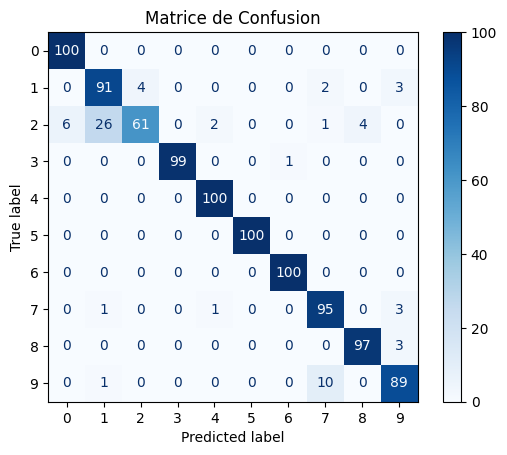

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ==============================================================================
# 1. CONFIGURATION ET CHARGEMENT DES DONNÉES (CHEMIN ABSOLU)
# ==============================================================================

# Modifie ce chemin selon ton besoin
DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"

df = pd.DataFrame(columns=['x', 'y', 'z', 't', 'gesture', 'subject', 'iter'])

print(f"--- Début du Chargement ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

for subject in range(1, 11): 
    for number in range(0, 10): # Adapté pour inclure le geste '0' si présent
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture avec saut de lignes (skiprows=5) pour ignorer les headers inutiles
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: 
                    continue 
                
                # Nettoyage des données (cas où tout est dans une seule colonne séparée par des virgules)
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion numérique et nettoyage des NaNs
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                
                df = pd.concat([df, file_df], ignore_index=True)
            
            except FileNotFoundError:
                continue
            except Exception:
                continue

print(f"Nombre total d'observations chargées : {len(df)}")

# Conversion finale des types
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

# ===========================================================
# 2. PRÉPARATION (STANDARDISATION & RESAMPLING)
# ===========================================================

def standardize_gesture(df_group):
    res = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = res[axis].std()
        res[f"{axis}_std"] = (res[axis] - res[axis].mean()) / std if std != 0 else 0
    return res

print("Standardisation des données...")
df = df.groupby(["subject", "gesture", "iter"], group_keys=False).apply(standardize_gesture)

def resample_gesture(df_input, target_len=100):
    resampled_data = []
    groups = df_input.groupby(["gesture", "subject", "iter"])
    
    for (gesture, subject, iteration), group in groups:
        n = len(group)
        if n < 2: continue
        
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        
        res_dict = {
            "gesture": [gesture]*target_len,
            "subject": [subject]*target_len,
            "iter": [iteration]*target_len
        }
        
        for col in ["x_std", "y_std", "z_std"]:
            res_dict[col] = interp1d(original_idx, group[col], kind='linear')(target_idx)
            
        resampled_data.append(pd.DataFrame(res_dict))

    return pd.concat(resampled_data, ignore_index=True)

print("Resampling à 100 points...")
df100 = resample_gesture(df)

# ===========================================================
# 3. MODÈLE (CLUSTERING & EDIT DISTANCE)
# ===========================================================

def edit_distance(s1, s2):
    n, m = len(s1), len(s2)
    M = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n+1): M[i][0] = i
    for j in range(m+1): M[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            M[i][j] = min(M[i-1][j] + 1, M[i][j-1] + 1, M[i-1][j-1] + cost)
    return M[n][m]

def gesture_to_sequence(df_sym):
    seq_dict = defaultdict(list)
    for (gesture, subject, iteration), group in df_sym.groupby(["gesture", "subject", "iter"]):
        seq = "".join(group["symbol"].tolist())
        seq_dict[gesture].append(seq)
    return seq_dict

def cluster_and_convert(df_train, df_test, k_clusters=50):
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    train_points = df_train[['x_std', 'y_std', 'z_std']].values
    kmeans.fit(train_points)

    def assign_symbols(df_local):
        pts = df_local[['x_std', 'y_std', 'z_std']].values
        clusters = kmeans.predict(pts)
        symbols = [chr(ord('A') + (c % 26)) for c in clusters]
        df_copy = df_local.copy()
        df_copy["symbol"] = symbols
        return df_copy

    return gesture_to_sequence(assign_symbols(df_train)), gesture_to_sequence(assign_symbols(df_test))

def knn_edit_predict(seq, train_dict, k=7):
    distances = []
    for gesture, sequences in train_dict.items():
        for s in sequences:
            d = edit_distance(seq, s)
            distances.append((gesture, d))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ===========================================================
# 4. CROSS-VALIDATION ET EVALUATION
# ===========================================================

def dict_creation_userout(df_in, subj_out):
    return df_in[df_in["subject"] != subj_out], df_in[df_in["subject"] == subj_out]

def testmodel(df_target, loop_range=10, k_knn=7, k_clusters=50):
    total_true, total_pred = [], []

    for i in range(1, loop_range + 1):
        print(f"Test sur sujet sorti : {i}")
        train_df, test_df = dict_creation_userout(df_target, i)
        
        if test_df.empty: continue

        train_seq, test_seq = cluster_and_convert(train_df, test_df, k_clusters)
        
        y_true, y_pred = [], [] 
        for gesture, sequences in test_seq.items():
            for seq in sequences:
                pred = knn_edit_predict(seq, train_seq, k=k_knn)
                y_true.append(gesture)
                y_pred.append(pred)

        total_true.extend(y_true)
        total_pred.extend(y_pred)
        print(f"Précision split : {accuracy_score(y_true, y_pred):.2%}")

    # Résultats finaux
    print(f"\n=== EXACTITUDE GLOBALE : {accuracy_score(total_true, total_pred):.2%} ===")
    cm = confusion_matrix(total_true, total_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title("Matrice de Confusion")
    plt.show()

# LANCEMENT
testmodel(df100)

# lcss cluser 20 knn 3 cluseter dedans 

--- Début du Chargement ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_17644\1356518853.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file_df], ignore_index=True)


Nombre total d'observations chargées : 99529
Standardisation en cours...


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_17644\1356518853.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


Resampling en cours...

--- TEST SUJET SORTI : 1 ---
Précision sujet 1 : 99.00%

--- TEST SUJET SORTI : 2 ---
Précision sujet 2 : 88.00%

--- TEST SUJET SORTI : 3 ---
Précision sujet 3 : 98.00%

--- TEST SUJET SORTI : 4 ---
Précision sujet 4 : 98.00%

--- TEST SUJET SORTI : 5 ---
Précision sujet 5 : 92.00%

--- TEST SUJET SORTI : 6 ---
Précision sujet 6 : 76.00%

--- TEST SUJET SORTI : 7 ---
Précision sujet 7 : 89.00%

--- TEST SUJET SORTI : 8 ---
Précision sujet 8 : 97.00%

--- TEST SUJET SORTI : 9 ---
Précision sujet 9 : 95.00%

--- TEST SUJET SORTI : 10 ---
Précision sujet 10 : 95.00%

=== EXACTITUDE GLOBALE KNN-LCSS : 92.70% ===


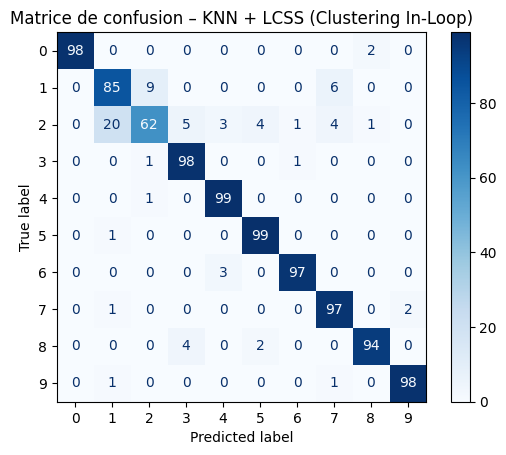

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ===========================================================
# 1. CHARGEMENT SÉCURISÉ DES DONNÉES (CHEMIN ABSOLU)
# ===========================================================

# Modifie ce chemin selon ton besoin
DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"

df = pd.DataFrame(columns=['x', 'y', 'z', 't', 'gesture', 'subject', 'iter'])

print(f"--- Début du Chargement ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

for subject in range(1, 11): 
    for number in range(0, 10): 
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture avec saut de lignes (skiprows=5) pour ignorer les headers inutiles
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: 
                    continue 
                
                # Nettoyage des données (cas où tout est dans une seule colonne séparée par des virgules)
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion numérique et nettoyage des NaNs
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                
                df = pd.concat([df, file_df], ignore_index=True)
            
            except FileNotFoundError:
                continue
            except Exception:
                continue

# Conversion finale des types pour les colonnes de catégories
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"Nombre total d'observations chargées : {len(df)}")

# ===========================================================
# 2. PRÉTRAITEMENT (STANDARDISATION & RESAMPLING)
# ===========================================================

def standardize_gesture(df_group):
    res = df_group.copy()
    for axis in ['x', 'y', 'z']:
        # Éviter la division par zéro si std est nul
        std = res[axis].std()
        res[f'{axis}_std'] = (res[axis] - res[axis].mean()) / std if std != 0 else 0
    return res

print("Standardisation en cours...")
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df_input, target_len=100):
    resampled_data = []
    for (gesture, subject, iteration), group in df_input.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col], kind='linear')(target_idx)

        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iteration] * target_len,
            'x_std': interp('x_std'),
            'y_std': interp('y_std'),
            'z_std': interp('z_std')
        }))
    return pd.concat(resampled_data, ignore_index=True)

print("Resampling en cours...")
df100 = resample_gesture(df)

# ===========================================================
# 3. LOGIQUE CLUSTERING ET CONVERSION (INTERNE AU SPLIT)
# ===========================================================

def cluster_and_symbolize(train_df, test_df, k_clusters=20):
    # Fit KMeans UNIQUEMENT sur les points du Train
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    train_points = train_df[['x_std', 'y_std', 'z_std']].values
    kmeans.fit(train_points)

    def to_seq_dict(df_target):
        pts = df_target[['x_std', 'y_std', 'z_std']].values
        clusters = kmeans.predict(pts)
        # Conversion index cluster -> Caractère A, B, C...
        symbols = [chr(ord('A') + (c % 26)) for c in clusters]
        
        temp_df = df_target.copy()
        temp_df['symbol'] = symbols
        
        seq_dict = defaultdict(list)
        for (gest, subj, it), group in temp_df.groupby(['gesture', 'subject', 'iter']):
            seq_dict[gest].append("".join(group['symbol'].tolist()))
        return seq_dict

    return to_seq_dict(train_df), to_seq_dict(test_df)

# ===========================================================
# 4. ALGORITHME LCSS
# ===========================================================

def lcs_length(s1, s2):
    n, m = len(s1), len(s2)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(1, n+1):
        for j in range(1, m+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    return dp[n][m]

def lcs_distance(s1, s2):
    # Transformation de la similarité LCS en distance
    return len(s1) + len(s2) - 2 * lcs_length(s1, s2)

def knn_lcs_predict(seq, train_dict, k=3):
    distances = []
    for gesture, sequences in train_dict.items():
        for s in sequences:
            d = lcs_distance(seq, s)
            distances.append((gesture, d))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ===========================================================
# 5. CROSS-VALIDATION ET TEST FINAL
# ===========================================================

def testmodel(df_input, loop_range=10, k_knn=3, k_clusters=20):
    total_true, total_pred = [], []

    for i in range(1, loop_range + 1):
        # Séparation User-Out
        train_df = df_input[df_input["subject"] != i]
        test_df = df_input[df_input["subject"] == i]
        
        if test_df.empty: 
            continue

        print(f"\n--- TEST SUJET SORTI : {i} ---")

        # Clustering + Symbolisation (Ré-entraîné sur chaque split)
        train_dict, test_dict = cluster_and_symbolize(train_df, test_df, k_clusters)

        y_true, y_pred = [], []
        for gesture, sequences in test_dict.items():
            for seq in sequences:
                pred = knn_lcs_predict(seq, train_dict, k=k_knn)
                y_true.append(gesture)
                y_pred.append(pred)

        acc = accuracy_score(y_true, y_pred)
        print(f"Précision sujet {i} : {acc:.2%}")
        total_true.extend(y_true)
        total_pred.extend(y_pred)

    final_acc = accuracy_score(total_true, total_pred)
    print(f"\n=== EXACTITUDE GLOBALE KNN-LCSS : {final_acc:.2%} ===")
    
    # Affichage Matrice de Confusion
    cm = confusion_matrix(total_true, total_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion – KNN + LCSS (Clustering In-Loop)")
    plt.show()

# LANCEMENT DU TEST
testmodel(df100)

# transformer 

--- 1. Début du Chargement du Domaine 3 ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé
Nombre total d'observations chargées : 99529


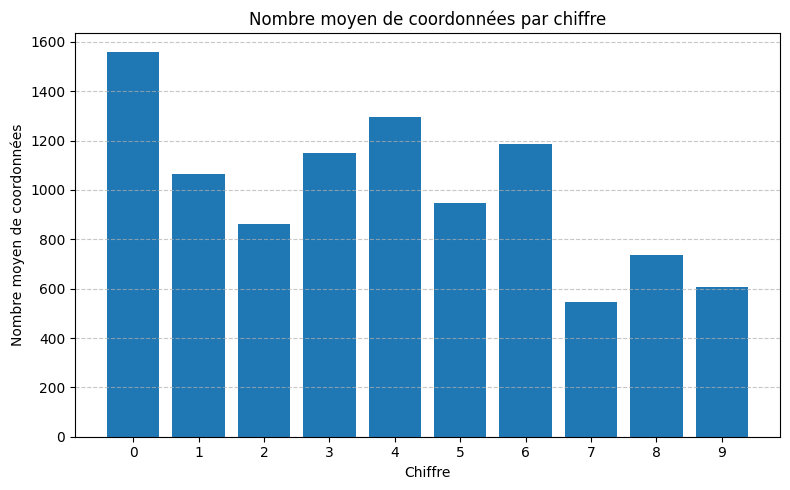

Chiffre 0 : 7534.30 s
Chiffre 1 : 5800.70 s
Chiffre 2 : 4499.00 s
Chiffre 3 : 7059.90 s
Chiffre 4 : 7407.10 s
Chiffre 5 : 4318.60 s
Chiffre 6 : 5602.90 s
Chiffre 7 : 2794.70 s
Chiffre 8 : 4108.20 s
Chiffre 9 : 2912.20 s


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_17976\3730711776.py:108: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)



--- Test subject OUT : 1 ---

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.0989 - loss: 2.4177
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.6056 - loss: 1.1200
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.9278 - loss: 0.2293
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.9489 - loss: 0.1548
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.9400 - loss: 0.2008
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.9789 - loss: 0.0858
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9800 - loss: 0.0692
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.9900 - loss: 0.0365
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.9978 - loss: 0.0118
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 1.0000 - loss: 0.0044
Epoch 12/50
29/29 ━━

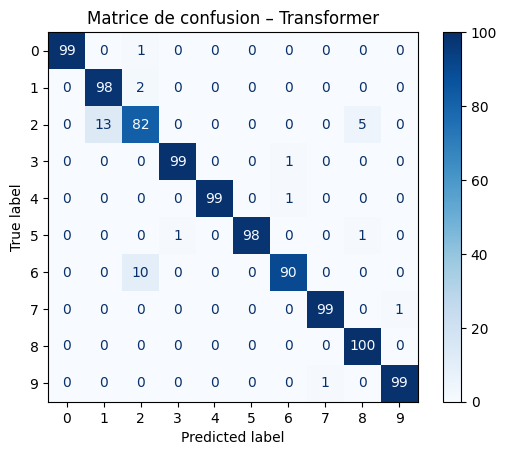

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorflow.keras import layers, models
import tensorflow as tf

# ==============================================================================
# 1. CHARGEMENT DES DONNÉES (Chemin Absolu & Lecture Robuste)
# ==============================================================================

# **CHEMIN ABSOLU**
DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"
DOMAIN_ID = 3

# Création d'une liste pour accumuler les données (plus rapide que concat dans la boucle)
df_list = []

print(f"--- 1. Début du Chargement du Domaine {DOMAIN_ID} ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

for subject in range(1, 11):
    for number in range(0, 10): # Ajusté de 0 à 9 pour couvrir les 10 gestes
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture robuste : Skiprows=5 pour passer l'entête spécifique au domaine
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: continue 
                
                # Séparation de la chaîne unique de coordonnées "x,y,z,t"
                data = file[0].str.strip('"').str.split(',', expand=True)
                
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion en numérique
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                
                df_list.append(file_df)
            
            except FileNotFoundError:
                continue 
            except Exception:
                continue

# Création du DataFrame final
if not df_list:
    raise ValueError("Aucun fichier n'a pu être chargé. Vérifiez le chemin et le format des fichiers.")

df = pd.concat(df_list, ignore_index=True)

# Conversion finale des types
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"Nombre total d'observations chargées : {len(df)}")

# ==============================================================================
# 2. ANALYSE EXPLORATOIRE
# ==============================================================================

grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean().reset_index()
mean_lengths.columns = ['Chiffre', 'Frames moyennes']

plt.figure(figsize=(8, 5))
plt.bar(mean_lengths["Chiffre"], mean_lengths["Frames moyennes"])
plt.title("Nombre moyen de coordonnées par chiffre")
plt.xlabel("Chiffre")
plt.ylabel("Nombre moyen de coordonnées")
plt.xticks(mean_lengths["Chiffre"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")


# ==============================================================================
# 3. STANDARDISATION
# ==============================================================================

def standardize_gesture(df_group):
    df_copy = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = df_copy[axis].std()
        if std == 0 or np.isnan(std):
            df_copy[f'{axis}_std'] = 0.0
        else:
            df_copy[f'{axis}_std'] = (df_copy[axis] - df_copy[axis].mean()) / std
    return df_copy

df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


# ==============================================================================
# 4. RESAMPLING À LONGUEUR FIXE
# ==============================================================================

def resample_gesture(df_in, target_len=100):
    resampled_data = []

    for (gesture, subject, iteration), group in df_in.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col].values, kind='linear', fill_value="extrapolate")(target_idx)

        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iteration] * target_len,
            'x_std': interp('x_std'),
            'y_std': interp('y_std'),
            'z_std': interp('z_std')
        }))

    return pd.concat(resampled_data, ignore_index=True)

df100 = resample_gesture(df)


# ==============================================================================
# 5. SPLIT USER-INDEPENDENT
# ==============================================================================

def create_user_independent_split(df_in, subj_out):
    train_df = df_in[df_in['subject'] != subj_out]
    test_df = df_in[df_in['subject'] == subj_out]

    def df_to_array(df_target):
        X, y = [], []
        for (gesture, subject, iteration), group in df_target.groupby(['gesture', 'subject', 'iter']):
            X.append(group[['x_std', 'y_std', 'z_std']].values)
            y.append(gesture)
        return np.array(X), np.array(y)

    X_train, y_train = df_to_array(train_df)
    X_test, y_test = df_to_array(test_df)
    return X_train, y_train, X_test, y_test


# ==============================================================================
# 6. POSITIONAL ENCODING
# ==============================================================================

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.positional_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_encoding[:, :seq_len, :]


# ==============================================================================
# 7. TRANSFORMER ENCODER MODEL
# ==============================================================================

def transformer_encoder(x, num_heads, d_model, dff, dropout):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = models.Sequential([
        layers.Dense(dff, activation="relu"),
        layers.Dense(d_model),
    ])
    ffn_output = ffn(out1)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

def create_transformer_model(input_shape, num_classes, seq_len=100):
    inputs = layers.Input(shape=input_shape)
    d_model, num_heads, num_layers, dff, dropout = 128, 8, 2, 256, 0.2

    x = layers.Dense(d_model)(inputs)
    x = PositionalEncoding(seq_len, d_model)(x)

    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, d_model, dff, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# ==============================================================================
# 8. TEST LEAVE-ONE-USER-OUT
# ==============================================================================

def test_transformer_user_independent(df_data, loop_range=10, epochs=30, batch_size=32, verbose_fit=1):
    total_true, total_pred = [], []

    for subj_out in range(1, loop_range + 1):
        if df_data[df_data['subject'] == subj_out].empty: continue
        
        print(f"\n--- Test subject OUT : {subj_out} ---")
        X_train, y_train, X_test, y_test = create_user_independent_split(df_data, subj_out)
        
        n_classes = len(np.unique(df_data['gesture']))
        input_shape = (X_train.shape[1], X_train.shape[2])

        model = create_transformer_model(input_shape=input_shape, num_classes=n_classes)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose_fit)

        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        acc = accuracy_score(y_test, y_pred)
        print(f"Exactitude subject {subj_out} : {acc:.2%}")

        total_true.extend(y_test)
        total_pred.extend(y_pred)

    final_acc = accuracy_score(total_true, total_pred)
    print(f"\nExactitude globale Transformer : {final_acc:.2%}")

    cm = confusion_matrix(total_true, total_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion – Transformer")
    plt.show()

# ==============================================================================
# 9. LANCEMENT
# ==============================================================================
test_transformer_user_independent(df100, loop_range=10, epochs=50, batch_size=32, verbose_fit=1)

#lstm

--- 1. Début du Chargement du Domaine 3 ---
Dossier source : \\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé
✅ Nombre total d'observations chargées : 99529

--- 2. Analyse Exploratoire ---


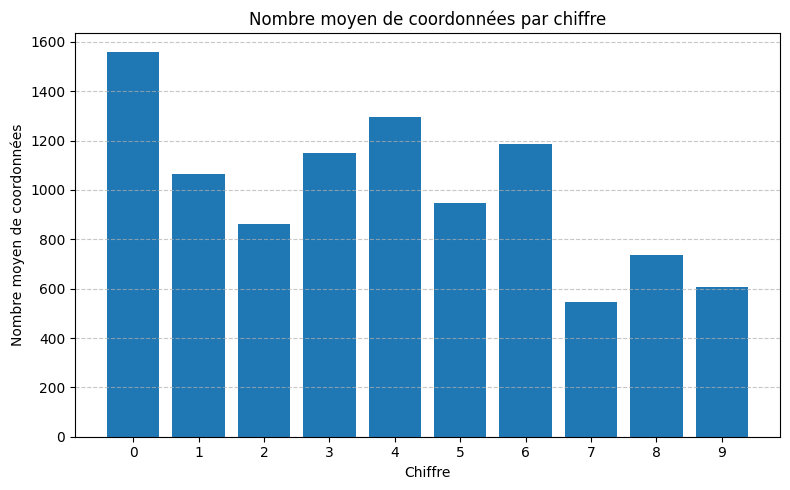

Chiffre 0 : 7534.30 s
Chiffre 1 : 5800.70 s
Chiffre 2 : 4499.00 s
Chiffre 3 : 7059.90 s
Chiffre 4 : 7407.10 s
Chiffre 5 : 4318.60 s
Chiffre 6 : 5602.90 s
Chiffre 7 : 2794.70 s
Chiffre 8 : 4108.20 s
Chiffre 9 : 2912.20 s

Standardisation...


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_21324\2725923359.py:105: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


Resampling à longueur 100...

--- Test subject OUT : 1 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 1 : 95.00%

--- Test subject OUT : 2 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 2 : 99.00%

--- Test subject OUT : 3 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 3 : 94.00%

--- Test subject OUT : 4 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 4 : 96.00%

--- Test subject OUT : 5 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 5 : 88.00%

--- Test subject OUT : 6 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 6 : 90.00%

--- Test subject OUT : 7 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 7 : 90.00%

--- Test subject OUT : 8 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 8 : 100.00%

--- Test subject OUT : 9 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 9 : 94.00%

--- Test subject OUT : 10 ---


\\student.fucam.ac.be\users$\isadiki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Exactitude subject 10 : 94.00%

Exactitude globale LSTM : 94.00%


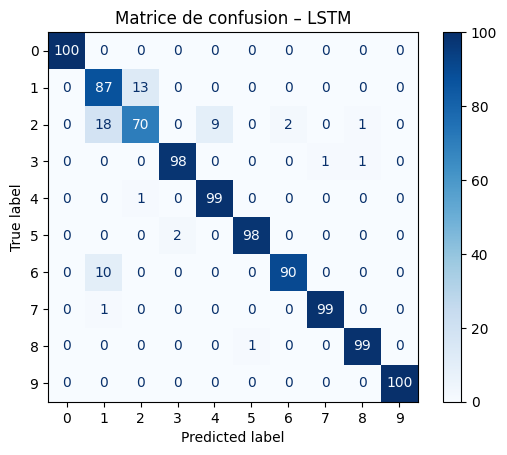

In [2]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorflow.keras import models, layers

# ==============================================================================
# 1. CHARGEMENT DES DONNÉES (Chemin Absolu & Lecture Robuste)
# ==============================================================================

# **CHEMIN ABSOLU À ADAPTER**
DOMAIN_FOLDER = r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"
DOMAIN_ID = 3

df_list = []

print(f"--- 1. Début du Chargement du Domaine {DOMAIN_ID} ---")
print(f"Dossier source : {DOMAIN_FOLDER}")

for subject in range(1, 11):
    for number in range(0, 10):
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture robuste : Skiprows=5 pour passer l'entête
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: continue 
                
                # Séparation de la chaîne unique de coordonnées "x,y,z,t"
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion en numérique
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = number
                file_df['subject'] = subject
                file_df['iter'] = iteration
                
                df_list.append(file_df)
            
            except (FileNotFoundError, Exception):
                continue

# Création du DataFrame final
if not df_list:
    raise ValueError("❌ Aucun fichier n'a été chargé. Vérifiez le chemin : " + DOMAIN_FOLDER)

df = pd.concat(df_list, ignore_index=True)

# Conversion finale des colonnes pour le traitement
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"✅ Nombre total d'observations chargées : {len(df)}")

# ==============================================================================
# 2. ANALYSE EXPLORATOIRE
# ==============================================================================

print("\n--- 2. Analyse Exploratoire ---")
grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean().reset_index()
mean_lengths.columns = ['Chiffre', 'Frames moyennes']

plt.figure(figsize=(8, 5))
plt.bar(mean_lengths["Chiffre"], mean_lengths["Frames moyennes"])
plt.title("Nombre moyen de coordonnées par chiffre")
plt.xlabel("Chiffre")
plt.ylabel("Nombre moyen de coordonnées")
plt.xticks(mean_lengths["Chiffre"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")

# ==============================================================================
# 3. PRÉTRAITEMENT (Standardisation & Resampling)
# ==============================================================================

def standardize_gesture(df_group):
    df_copy = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = df_copy[axis].std()
        if std == 0 or np.isnan(std):
            df_copy[f'{axis}_std'] = 0.0
        else:
            df_copy[f'{axis}_std'] = (df_copy[axis] - df_copy[axis].mean()) / std
    return df_copy

print("\nStandardisation...")
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df_in, target_len=100):
    resampled_data = []
    for (gesture, subject, iteration), group in df_in.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col].values, kind='linear', fill_value="extrapolate")(target_idx)

        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iteration] * target_len,
            'x_std': interp('x_std'),
            'y_std': interp('y_std'),
            'z_std': interp('z_std')
        }))
    return pd.concat(resampled_data, ignore_index=True)

print("Resampling à longueur 100...")
df100 = resample_gesture(df)

# ==============================================================================
# 4. SPLIT USER-INDEPENDENT
# ==============================================================================

def create_user_independent_split(df_in, subj_out):
    train_df = df_in[df_in['subject'] != subj_out]
    test_df = df_in[df_in['subject'] == subj_out]

    def df_to_array(df_target):
        X, y = [], []
        for (gesture, subject, iteration), group in df_target.groupby(['gesture', 'subject', 'iter']):
            X.append(group[['x_std', 'y_std', 'z_std']].values)
            y.append(gesture)
        return np.array(X), np.array(y)

    X_train, y_train = df_to_array(train_df)
    X_test, y_test = df_to_array(test_df)
    return X_train, y_train, X_test, y_test

# ==============================================================================
# 5. MODÈLE LSTM
# ==============================================================================

def create_lstm_model(input_shape, num_classes):
    model = models.Sequential([
        layers.LSTM(256, return_sequences=True, dropout=0.2, input_shape=input_shape),
        layers.LSTM(256, dropout=0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================================================================
# 6. TEST DU MODÈLE LSTM (Validation Croisée)
# ==============================================================================

def test_lstm_user_independent(df_data, loop_range=10, epochs=50, batch_size=16):
    total_true, total_pred = [], []
    subjects = sorted(df_data['subject'].unique())

    for subj_out in subjects:
        print(f"\n--- Test subject OUT : {subj_out} ---")
        X_train, y_train, X_test, y_test = create_user_independent_split(df_data, subj_out)

        # Calculer le nombre réel de classes présentes
        all_labels = np.unique(df_data['gesture'])
        num_classes = int(max(all_labels) + 1)

        model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)
        
        # Entraînement
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prédiction
        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        acc = accuracy_score(y_test, y_pred)
        print(f"Exactitude subject {subj_out} : {acc:.2%}")

        total_true.extend(y_test)
        total_pred.extend(y_pred)

    final_acc = accuracy_score(total_true, total_pred)
    print(f"\nExactitude globale LSTM : {final_acc:.2%}")

    # Matrice de confusion
    cm = confusion_matrix(total_true, total_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion – LSTM")
    plt.show()

# ==============================================================================
# 7. LANCER LE TEST
# ==============================================================================
test_lstm_user_independent(df100)

#dtw

--- Début du Chargement ---
✅ Données chargées : 99529 lignes.


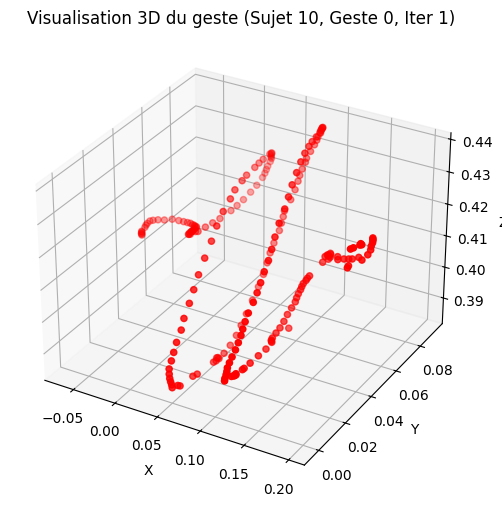


--- Durée moyenne des gestes (s) ---
gesture
0    7534.3
1    5800.7
2    4499.0
3    7059.9
4    7407.1
5    4318.6
6    5602.9
7    2794.7
8    4108.2
9    2912.2
Name: duration, dtype: float64


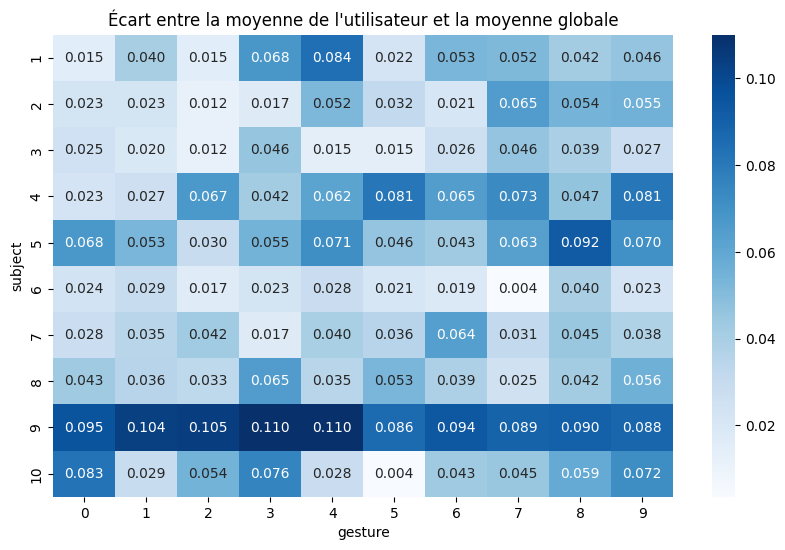

Standardisation...


C:\Users\Isadiki\AppData\Local\Temp\ipykernel_10748\1713659362.py:112: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


Resampling...

--- Test Split OUT : 1 ---
Précision split 1 : 98.00%

--- Test Split OUT : 2 ---
Précision split 2 : 94.00%

--- Test Split OUT : 3 ---
Précision split 3 : 100.00%

--- Test Split OUT : 4 ---
Précision split 4 : 100.00%

--- Test Split OUT : 5 ---
Précision split 5 : 96.00%

--- Test Split OUT : 6 ---
Précision split 6 : 86.00%

--- Test Split OUT : 7 ---
Précision split 7 : 95.00%

--- Test Split OUT : 8 ---
Précision split 8 : 98.00%

--- Test Split OUT : 9 ---
Précision split 9 : 100.00%

--- Test Split OUT : 10 ---
Précision split 10 : 99.00%

✅ Précision GLOBALE : 96.60%


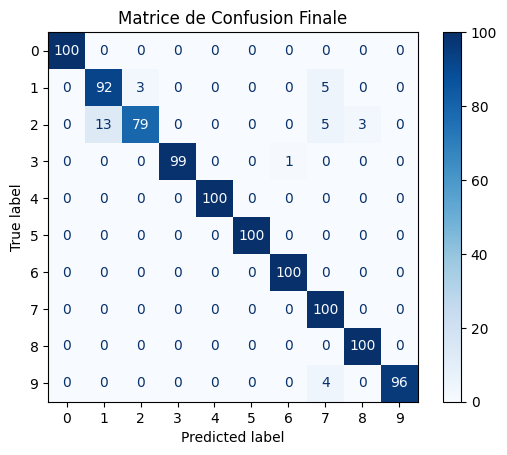

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import seaborn as sns

# ==============================================================================
# 1. CONFIGURATION ET CHARGEMENT DES DONNÉES
# ==============================================================================

DOMAIN_FOLDER =r"\\student.fucam.ac.be\users$\isadiki\Downloads\Domain3base\DOMAIN3_CSVcorrigé"

df_list = []

print("--- Début du Chargement ---")
for subject in range(1, 11): 
    for number in range(0, 10): 
        for iteration in range(1, 11):
            filename = os.path.join(DOMAIN_FOLDER, f'Subject{subject}-{number}-{iteration}.csv')
            
            try:
                # Lecture sautant les 5 lignes de header (Domaine 4)
                file = pd.read_csv(filename, skiprows=5, header=None)
                
                if file.empty or file.shape[0] < 2: 
                    continue 
                
                # Parsing : séparation de la chaîne par les virgules
                data = file[0].str.strip('"').str.split(',', expand=True)
                file_df = pd.DataFrame(data.iloc[:, :4].values, columns=['x', 'y', 'z', 't'])
                
                # Conversion numérique
                for col in ['x', 'y', 'z', 't']:
                    file_df[col] = pd.to_numeric(file_df[col], errors='coerce')
                file_df.dropna(subset=['x', 'y', 'z', 't'], inplace=True)
                
                # Ajout des meta-données
                file_df['gesture'] = int(number)
                file_df['subject'] = int(subject)
                file_df['iter'] = int(iteration)
                
                df_list.append(file_df)
            except:
                continue

if not df_list:
    raise ValueError("❌ Aucun fichier chargé. Vérifiez le chemin : " + DOMAIN_FOLDER)

df = pd.concat(df_list, ignore_index=True)
for col in ['gesture', 'subject', 'iter']:
    df[col] = df[col].astype(int)

print(f"✅ Données chargées : {len(df)} lignes.")

# ==============================================================================
# 2. VISUALISATION 3D D'UN GESTE (Ex: Geste 0) - TRACÉ BLEU ENLEVÉ
# ==============================================================================

subdf = df.loc[(df['gesture'] == 0) & (df['subject'] == 10) & (df['iter'] == 1)]

if not subdf.empty:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot(...) a été supprimé ici pour enlever le tracé bleu
    ax.scatter(subdf['x'], subdf['y'], subdf['z'], c='red', s=20)
    ax.set_title("Visualisation 3D du geste (Sujet 10, Geste 0, Iter 1)")
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.show()

# ==============================================================================
# 3. ANALYSE EXPLORATOIRE (Stats & Heatmap)
# ==============================================================================

# Durée moyenne des gestes
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
print("\n--- Durée moyenne des gestes (s) ---")
print(mean_durations)

# Heatmap des distances moyennes par utilisateur
mean_coords_user = df.groupby(['subject', 'gesture'])[['x', 'y', 'z']].mean().reset_index()
mean_coords_global = df.groupby('gesture')[['x', 'y', 'z']].mean().reset_index().rename(
    columns={'x':'x_global', 'y':'y_global', 'z':'z_global'})

merged = pd.merge(mean_coords_user, mean_coords_global, on='gesture')
merged['dist_to_global'] = np.sqrt((merged['x']-merged['x_global'])**2 + 
                                   (merged['y']-merged['y_global'])**2 + 
                                   (merged['z']-merged['z_global'])**2)

pivot = merged.pivot(index='subject', columns='gesture', values='dist_to_global')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='Blues')
plt.title("Écart entre la moyenne de l'utilisateur et la moyenne globale")
plt.show()

# ==============================================================================
# 4. PRÉ-TRAITEMENT (Standardisation & Resampling)
# ==============================================================================

def standardize_gesture(df_group):
    df_res = df_group.copy()
    for axis in ['x', 'y', 'z']:
        std = df_res[axis].std()
        df_res[f'{axis}_std'] = (df_res[axis] - df_res[axis].mean()) / std if std != 0 else 0
    return df_res

print("Standardisation...")
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)

def resample_gesture(df, target_len=100):
    resampled_data = []
    for (gesture, subject, iteration), group in df.groupby(['gesture', 'subject', 'iter']):
        n = len(group)
        if n < 2: continue
        original_idx = np.arange(n)
        target_idx = np.linspace(0, n - 1, target_len)
        interp = lambda col: interp1d(original_idx, group[col], kind='linear')(target_idx)
        resampled_data.append(pd.DataFrame({
            'gesture': [gesture] * target_len, 'subject': [subject] * target_len, 'iter': [iteration] * target_len,
            'x_std': interp('x_std'), 'y_std': interp('y_std'), 'z_std': interp('z_std')
        }))
    return pd.concat(resampled_data, ignore_index=True)

print("Resampling...")
df100 = resample_gesture(df)

# ==============================================================================
# 5. ALGORITHME KNN + DTW
# ==============================================================================

def eucl_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def dtw_dist(seq1, seq2):
    n, m = len(seq1), len(seq2)
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = eucl_dist(seq1[i-1], seq2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]

def knn_dtw_predict(reference_seq, train_dict, k=3):
    distances = []
    for gesture, sequences in train_dict.items():
        for seq in sequences:
            dist = dtw_dist(reference_seq, seq)
            distances.append((gesture, dist))
    distances.sort(key=lambda x: x[1])
    k_nearest = distances[:k]
    votes = Counter([g for g, _ in k_nearest])
    return votes.most_common(1)[0][0]

# ==============================================================================
# 6. VALIDATION CROISÉE ET TESTS
# ==============================================================================

def dict_creation_userout(df, subj_out):
    test_df = df[df["subject"] == subj_out]
    train_df = df[df["subject"] != subj_out]
    
    dict_train = defaultdict(list)
    dict_test = defaultdict(list)

    for (g, s, it), group in train_df.groupby(["gesture", "subject", "iter"]):
        dict_train[g].append(group[["x_std", "y_std", "z_std"]].values.tolist())
    for (g, s, it), group in test_df.groupby(["gesture", "subject", "iter"]):
        dict_test[g].append(group[["x_std", "y_std", "z_std"]].values.tolist())
    return dict_train, dict_test

def testmodel(DictCreationFunc, df, loop_range=10, k=3):
    total_true, total_pred = [], []
    for i in range(1, loop_range + 1):
        print(f"\n--- Test Split OUT : {i} ---")
        coord_train, coord_test = DictCreationFunc(df, i)
        y_true, y_pred = [], []
        for gesture, sequences in coord_test.items():
            for seq in sequences:
                pred = knn_dtw_predict(seq, coord_train, k=k)
                y_true.append(gesture)
                y_pred.append(pred)
        
        acc = accuracy_score(y_true, y_pred)
        total_true.extend(y_true); total_pred.extend(y_pred)
        print(f"Précision split {i} : {acc:.2%}")

    print(f"\n✅ Précision GLOBALE : {accuracy_score(total_true, total_pred):.2%}")
    cm = confusion_matrix(total_true, total_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title("Matrice de Confusion Finale")
    plt.show()

# LANCEMENT FINAL
testmodel(dict_creation_userout, df100, loop_range=10, k=3)